<a href="https://colab.research.google.com/github/it21813702/ML_Assignment_1/blob/main/ML_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Loading and Initial Exploration

In [1]:
# import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')


In [2]:
# load the dataset
df = pd.read_csv('Loan_default.csv')

# print some basic infor about the dataset
print("dataset shape:", df.shape)

# print the initial rows of the dataset, can specidy how many by including a num in the brackets
df.head(3)


dataset shape: (226402, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0.0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0.0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1.0



Missing Values per column: 
LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     1
HasMortgage       1
HasDependents     1
LoanPurpose       1
HasCoSigner       1
Default           1
dtype: int64

Summary statistics:
                 Age         Income     LoanAmount    CreditScore  \
count  226402.000000  226402.000000  226402.000000  226402.000000   
mean       43.482067   82466.092658  127487.330947     574.335885   
std        14.985143   38971.631847   70821.634997     158.845439   
min        18.000000   15000.000000    5000.000000     300.000000   
25%        31.000000   48763.000000   66068.250000     437.000000   
50%        43.000000   82482.500000  127371.500000     574.000000   
75%        56.000000  116189.000000  188814.000000     712.000000   
max        69.000000  149

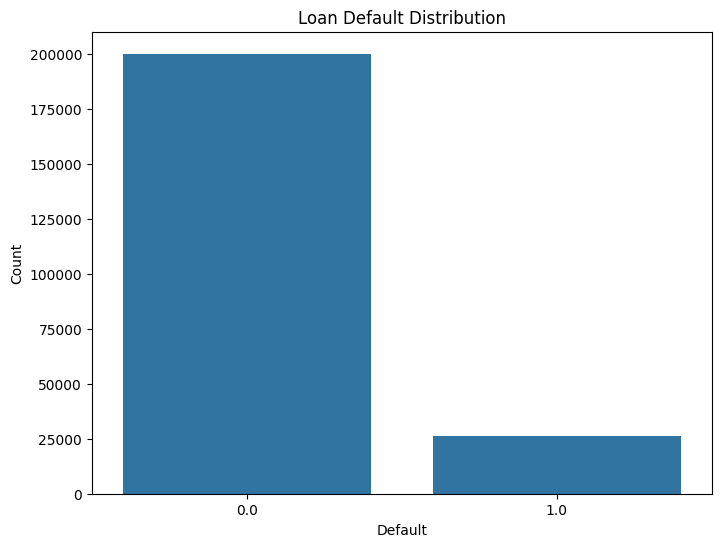

In [3]:
## further explore the dataset

# check for any missing values/nulls, etc..
print("\nMissing Values per column: ")
print(df.isnull().sum())

# get summary statistics
print("\nSummary statistics:")
print(df.describe())


# check the distribution of the target variable,(the loan default in this case)
print("\nTarget variable distribution:")
print(df['Default'].value_counts())
print(df['Default'].value_counts(normalize=True).round(4) * 100, "%")

# visualise the distribution of loan defaults
plt.figure(figsize=(8, 6))
sns.countplot(x='Default', data=df)
plt.title('Loan Default Distribution')
plt.ylabel('Count')
plt.show()


## Data Preprocessing and Cleaning

In [4]:
# identify the numerical and categorical features
numerical_features = ['Age', 'Income', 'LoanAmount', 'CreditScore',
                      'MonthsEmployed', 'NumCreditLines', 'InterestRate',
                      'LoanTerm', 'DTIRatio']

categorical_features = ['Education', 'EmploymentType', 'MaritalStatus',
                        'HasMortgage', 'HasDependents', 'LoanPurpose',
                        'HasCoSigner']


# check the categorical variables to understand their values
print("Examining categorical variables:")
for cat_feature in categorical_features:
    print(f"\n{cat_feature} value counts:")
    print(df[cat_feature].value_counts())

    print(f"Number of unique values: {df[cat_feature].nunique()}")


# identify and handle outliers in numerical features -- outliers affect logistic regression performance
# use IQR method to identify the outliers
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[ (df[column] < lower_bound) | (df[column] > upper_bound) ][column]

    return outliers.shape[0], lower_bound, upper_bound


# function to cap outliers to lower and upper bounds (winsorizing) -- this will help make the model's predictions more stable
def cap_outliers(df, column, lower_bound, upper_bound):
    df_copy = df.copy()
    df_copy[column] = df_copy[column].clip(lower=lower_bound, upper=upper_bound)

    return df_copy



# use the functions above to cap any outliers in numerical cols if they exist
print("\nOutlier Detection and Treatment:")
for col in numerical_features:
    # check for outliers
    outlier_count, lower_bound, upper_bound = identify_outliers(df, col)
    total_observations = len(df)
    outlier_percentage = (outlier_count / total_observations) * 100

    # print outlier stats for the current column
    print(f"{col}: {outlier_count} outliers ({outlier_percentage:.2f}% of data)")

    # can any outliers if they exist
    if outlier_count > 0:
        df = cap_outliers(df, col, lower_bound, upper_bound)

        print(f"  - Capped to range: [{lower_bound:.2f}, {upper_bound:.2f}]")





Examining categorical variables:

Education value counts:
Education
Bachelor's     57097
High School    56628
PhD            56365
Master's       56312
Name: count, dtype: int64
Number of unique values: 4

EmploymentType value counts:
EmploymentType
Part-time        56826
Self-employed    56597
Unemployed       56579
Full-time        56399
Sel                  1
Name: count, dtype: int64
Number of unique values: 5

MaritalStatus value counts:
MaritalStatus
Divorced    75560
Married     75424
Single      75417
Name: count, dtype: int64
Number of unique values: 3

HasMortgage value counts:
HasMortgage
Yes    113254
No     113147
Name: count, dtype: int64
Number of unique values: 2

HasDependents value counts:
HasDependents
No     113267
Yes    113134
Name: count, dtype: int64
Number of unique values: 2

LoanPurpose value counts:
LoanPurpose
Business     45490
Home         45348
Education    45256
Other        45182
Auto         45125
Name: count, dtype: int64
Number of unique values: 5



In [5]:
# check the values in each category
print("\nChecking actual values in categorical columns:")
for cat_feature in categorical_features:
    print(f"\n{cat_feature} unique values:")
    print(df[cat_feature].unique())

# define mapping functions with error handling
def safe_map(series, mapping_dict):
    # make a copy to avoid modifying the original series
    result = series.copy()

    # apply mapping only to values that exist in the mapping dictionary we created
    for old_val, new_val in mapping_dict.items():
        result = result.replace(old_val, new_val)

    return result


# After checking the actual values, adjust the mappings to match dataset
df['Education'] = safe_map(df['Education'], { 'High School': 0, "Bachelor's": 1, "Master's": 2, "PhD": 3})

df['EmploymentType'] = safe_map(df['EmploymentType'], {'Unemployed': 0, 'Self-employed': 1, 'Full-time': 2, 'Part-time': 3})

df['MaritalStatus'] = safe_map(df['MaritalStatus'], {'Single': 0, 'Married': 1, 'Divorced': 2})

df['HasMortgage'] = safe_map(df['HasMortgage'], {'No': 0, 'Yes': 1})

df['HasDependents'] = safe_map(df['HasDependents'], {'No': 0, 'Yes': 1})

df['HasCoSigner'] = safe_map(df['HasCoSigner'], {'No': 0, 'Yes': 1})


# Verify that the mapping worked correctly
print("\nVerifying categorical mappings:")
for cat_feature in categorical_features:
    if cat_feature != 'LoanPurpose':  # Skip LoanPurpose as it uses cat.codes
        print(f"\n{cat_feature} value counts after mapping:")
        print(df[cat_feature].value_counts())

# The LoanPurpose column conversion is already working correctly
df['LoanPurpose'] = df['LoanPurpose'].astype('category').cat.codes




Checking actual values in categorical columns:

Education unique values:
["Bachelor's" "Master's" 'High School' 'PhD']

EmploymentType unique values:
['Full-time' 'Unemployed' 'Self-employed' 'Part-time' 'Sel']

MaritalStatus unique values:
['Divorced' 'Married' 'Single' nan]

HasMortgage unique values:
['Yes' 'No' nan]

HasDependents unique values:
['Yes' 'No' nan]

LoanPurpose unique values:
['Other' 'Auto' 'Business' 'Home' 'Education' nan]

HasCoSigner unique values:
['Yes' 'No' nan]

Verifying categorical mappings:

Education value counts after mapping:
Education
1    57097
0    56628
3    56365
2    56312
Name: count, dtype: int64

EmploymentType value counts after mapping:
EmploymentType
3      56826
1      56597
0      56579
2      56399
Sel        1
Name: count, dtype: int64

MaritalStatus value counts after mapping:
MaritalStatus
2.0    75560
1.0    75424
0.0    75417
Name: count, dtype: int64

HasMortgage value counts after mapping:
HasMortgage
1.0    113254
0.0    113147
N

In [6]:
# check for duplicate rows of data
duplicate_count = df.duplicated().sum()
print(f"\nFound {duplicate_count} duplicate rows")

if duplicate_count > 0:
    # Remove duplicates
    df = df.drop_duplicates()
    print(f"Removed {duplicate_count} duplicate rows")



Found 0 duplicate rows


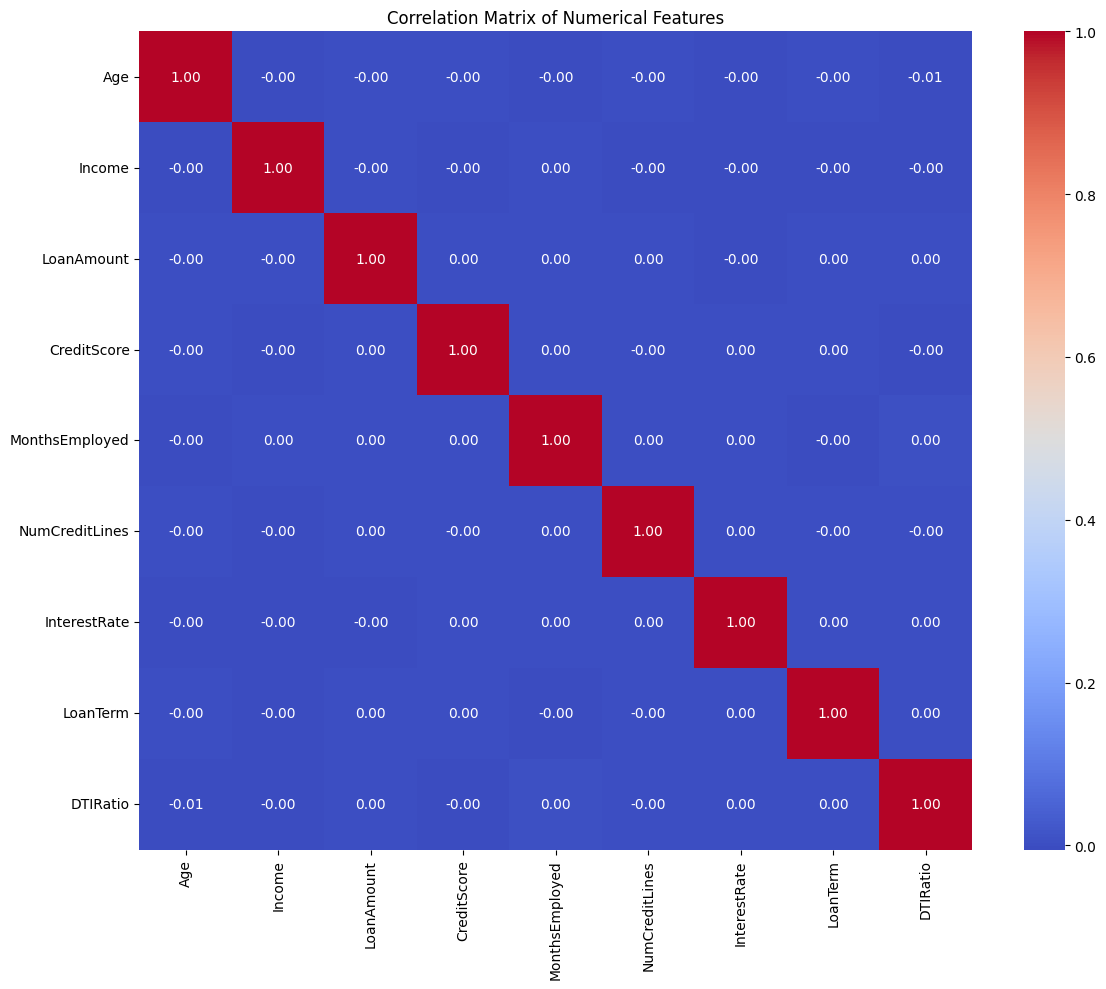

In [7]:
# examine the correlation between numerical features

# create a figure
plt.figure(figsize=(12, 10))

# compute the matrix
correlation_matrix = df[numerical_features].corr()

# generate the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# add title and adjust layout
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()

# display the plot
plt.show()

In [8]:
# Print a summary of the preprocessing steps performed
print("\nSummary of Preprocessing Steps:")
print("1. Identified numerical and categorical features")
print("2. Examined categorical variables")
print("3. Detected and capped outliers in numerical features")
print("4. Converted binary categorical variables to 0/1 format (if needed)")
print("5. Checked for and removed duplicate rows (if any)")
print("6. Examined correlations between numerical features")

# Show the dataset shape after preprocessing
print(f"\nDataset shape after preprocessing: {df.shape}")

# Check a sample of the preprocessed data
print("\nSample of preprocessed data:")
df.sample(20)


Summary of Preprocessing Steps:
1. Identified numerical and categorical features
2. Examined categorical variables
3. Detected and capped outliers in numerical features
4. Converted binary categorical variables to 0/1 format (if needed)
5. Checked for and removed duplicate rows (if any)
6. Examined correlations between numerical features

Dataset shape after preprocessing: (226402, 18)

Sample of preprocessed data:


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
56232,92E29A992Y,43,78850,183503,384,82,4,8.49,48,0.17,3,0,1.0,1.0,0.0,1,0.0,0.0
50698,05QFRP80WE,46,104138,54049,605,17,1,18.24,12,0.65,3,1,0.0,1.0,0.0,4,0.0,0.0
132615,X0HBV0CZ6I,31,122265,68185,624,95,2,10.05,24,0.35,0,2,1.0,1.0,1.0,3,1.0,0.0
85750,0PFP4NNWY0,44,41454,157177,454,111,3,5.86,60,0.89,1,2,0.0,1.0,1.0,4,1.0,0.0
114473,VFPHQBLO7V,45,56698,218717,601,110,4,7.10,60,0.44,2,3,2.0,0.0,0.0,4,1.0,0.0
174051,X032F3HCKK,47,36679,43243,348,55,3,5.80,24,0.82,2,3,0.0,0.0,1.0,0,1.0,0.0
160213,56FGIVX6LM,24,140488,239456,845,70,2,13.75,60,0.58,1,0,1.0,0.0,1.0,4,0.0,0.0
9283,U7USJYLGDY,49,111129,120235,466,109,1,24.32,48,0.65,0,0,1.0,0.0,0.0,2,1.0,0.0
93267,WKB5SPQHML,55,129221,135188,355,0,1,2.44,48,0.12,1,0,0.0,1.0,1.0,2,1.0,0.0
152581,IXQJGVWQDW,19,74226,200203,495,58,4,4.85,12,0.19,2,2,2.0,1.0,1.0,0,1.0,0.0


## Feature Engineering

Created: CreditScoreToLoanRatio
Created: MonthlyPayment
Created: PaymentToIncomeRatio
Created: EmploymentToLoanTermRatio
Created: AgeCreditInteraction
Created: DebtBurden
Created: AgeGroup

NaN counts after feature engineering:
MaritalStatus    1
HasMortgage      1
HasDependents    1
HasCoSigner      1
Default          1
dtype: int64
Filled NaN values in numerical columns with medians

Summary statistics of engineered features:
       CreditScoreToLoanRatio  MonthlyPayment  PaymentToIncomeRatio  \
count           226402.000000   226402.000000         226402.000000   
mean                 0.009186     5639.948597              1.157009   
std                  0.014183     4724.527481              1.469739   
min                  0.001205       90.802843              0.008192   
25%                  0.002991     2315.461201              0.335510   
50%                  0.004509     4436.246813              0.681689   
75%                  0.008691     7247.784903              1.397227   


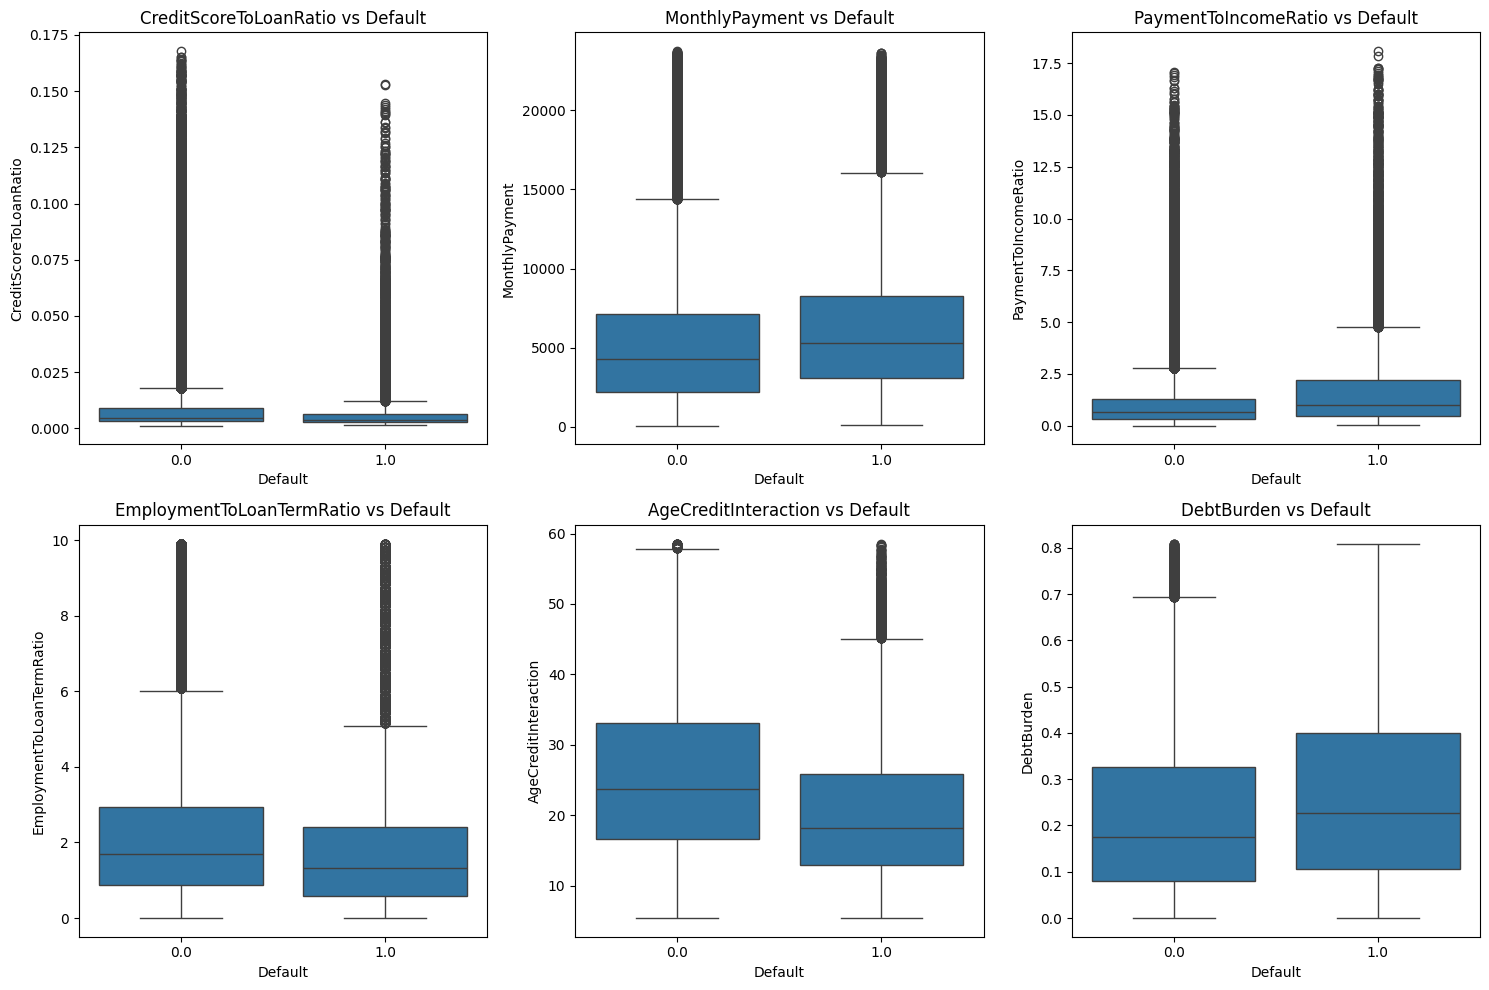

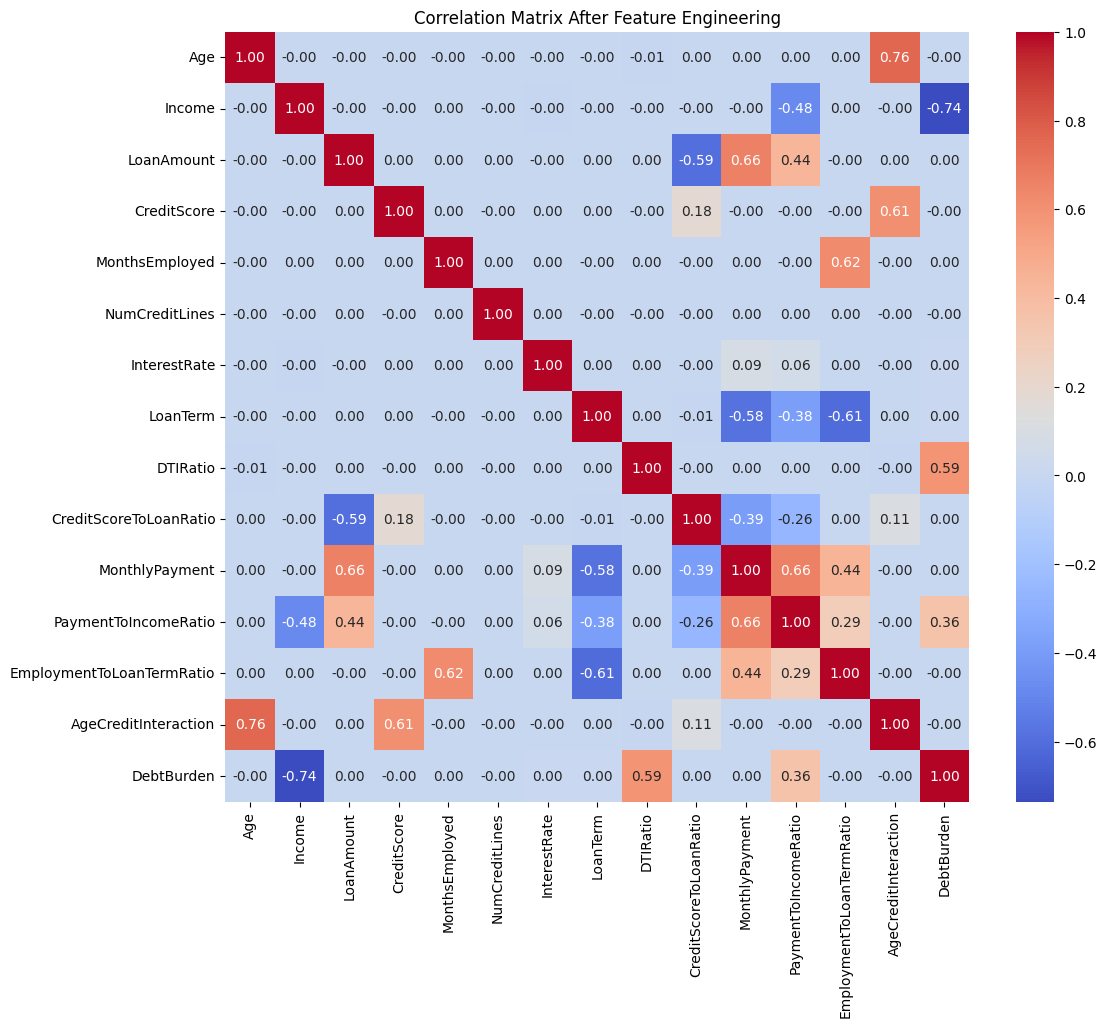


Highly correlated feature pairs (>0.75):
Age and AgeCreditInteraction: 0.76

Feature Engineering Summary:
Original features: 16
New features created: 7
Total features for modeling: 23
Highly correlated pairs: 1

Processed dataset shape: (226402, 26)
Sample of processed data:
            LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
49576   6YPZ9JYVPX   21  102180      198649          323              73   
134865  FJRYOLDI35   43   73815      236248          302               1   
191940  ETX5PW4YXB   36   78390      194350          307             101   

        NumCreditLines  InterestRate  LoanTerm  DTIRatio  ...  HasCoSigner  \
49576                1         18.28        60      0.21  ...          0.0   
134865               1          8.00        36      0.37  ...          0.0   
191940               3          9.70        24      0.49  ...          1.0   

       Default  CreditScoreToLoanRatio  MonthlyInterestRate  MonthlyPayment  \
49576      0.0            

In [9]:
# Measures creditworthiness per dollar borrowed.
df['CreditScoreToLoanRatio'] = df['CreditScore'] / df['LoanAmount']
print("Created: CreditScoreToLoanRatio")



# monthly payment calculation using the fixed-rate loan formula.
# PMT = P * (r*(1+r)^n) / ((1+r)^n - 1)  --> P = LoanAmount, r = MonthlyInterestRate, n = LoanTerm (in months)
df['MonthlyInterestRate'] = df['InterestRate'] / 100 / 12  # Convert annual % to monthly decimal rate

df['MonthlyPayment'] = df['LoanAmount'] * (
    df['MonthlyInterestRate'] * (1 + df['MonthlyInterestRate']) ** df['LoanTerm']
) / ((1 + df['MonthlyInterestRate']) ** df['LoanTerm'] - 1)

print("Created: MonthlyPayment")



# PaymentToIncomeRatio -- Assesses affordability by showing the percentage of annual income that goes toward loan payments.
df['PaymentToIncomeRatio'] = (df['MonthlyPayment'] * 12) / df['Income']
print("Created: PaymentToIncomeRatio")



# EmploymentToLoanTermRatio -- Indicates employment stability relative to the loan term.
df['EmploymentToLoanTermRatio'] = df['MonthsEmployed'] / df['LoanTerm']
print("Created: EmploymentToLoanTermRatio")



# AgeCreditInteraction -- Captures interaction effects between age and credit score.
# Dividing by 1000 scales the product for stability.
df['AgeCreditInteraction'] = (df['Age'] * df['CreditScore']) / 1000
print("Created: AgeCreditInteraction")



# DebtBurden -- Combines DTIRatio with income to reflect financial strain.
# Lower income increases the burden even for similar DTIRatio values.
df['DebtBurden'] = df['DTIRatio'] * (1 - (df['Income'] / df['Income'].max()))
print("Created: DebtBurden")



# AgeGroup (Binning) -- bins ages into categories to capture non-linear effects.
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['<25', '25-35', '35-45', '45-55', '55-65', '65+']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Convert the categorical bins to numeric codes for modeling
df['AgeGroup'] = df['AgeGroup'].astype('category').cat.codes
print("Created: AgeGroup")






# check for any NaN values created during this feature engineering process
nan_counts = df.isna().sum()
print("\nNaN counts after feature engineering:")
print(nan_counts[nan_counts > 0])  # Only list columns with NaN values


# handle any NaN values (if any)
if nan_counts.sum() > 0:
    # Fill NaN values in numerical columns with their median values
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
    print("Filled NaN values in numerical columns with medians")





# Explore the distribution of new features
engineered_features = [
    'CreditScoreToLoanRatio', 'MonthlyPayment', 'PaymentToIncomeRatio',
    'EmploymentToLoanTermRatio', 'AgeCreditInteraction', 'DebtBurden', 'AgeGroup'
]
print("\nSummary statistics of engineered features:")
print(df[engineered_features].describe())



# Visualize relationships between new features and the target variable
plt.figure(figsize=(15, 10))
# Exclude AgeGroup since it's categorical
for i, feature in enumerate(engineered_features[:6]):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='Default', y=feature, data=df)
    plt.title(f'{feature} vs Default')
plt.tight_layout()
plt.show()




# Update feature lists for modeling
# Original numerical features plus new engineered ones
updated_numerical_features = numerical_features + [
    'CreditScoreToLoanRatio', 'MonthlyPayment', 'PaymentToIncomeRatio',
    'EmploymentToLoanTermRatio', 'AgeCreditInteraction', 'DebtBurden'
]
# Original categorical features plus AgeGroup
updated_categorical_features = categorical_features + ['AgeGroup']




# Check for and handle potential multicollinearity
correlation_matrix = df[updated_numerical_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix After Feature Engineering')
plt.show()

print("\nHighly correlated feature pairs (>0.75):")
high_corr_pairs = []
for i in range(len(updated_numerical_features)):
    for j in range(i + 1, len(updated_numerical_features)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.75:
            high_corr_pairs.append((updated_numerical_features[i], updated_numerical_features[j], corr_value))
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")




# Summarize the feature engineering process
print("\nFeature Engineering Summary:")
print(f"Original features: {len(numerical_features) + len(categorical_features)}")
print(f"New features created: {len(engineered_features)}")
total_features = len(updated_numerical_features) + len(updated_categorical_features)
print(f"Total features for modeling: {total_features}")
print(f"Highly correlated pairs: {len(high_corr_pairs)}")

# Save the processed dataset for model training
df_processed = df.copy()
print("\nProcessed dataset shape:", df_processed.shape)
print("Sample of processed data:")
print(df_processed.sample(3))

## Data Splitting and Model Implementation